# Исследование для компании «Мегафон». Статистический анализ.

Как и любой бизнес, компания «Мегафон» хочет повысить удовлетворённость своих клиентов качеством услуг. Это важная задача для удержания пользователей — как давних, так и недавно привлечённых. <br>
Чтобы делать это наиболее эффективно, важно определить, **какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними**. Для этого «Мегафон» провёл опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. По каждому клиенту, прошедшему опрос, были собраны технические показатели. <br>

**Более подробно о проведённом опросе:**

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа.

![](https://sun9-32.userapi.com/C6vN5pHQW7hlseIt0AtTN7qNDQbDnHXdt1P2NA/ILntXqa-RrA.jpg)

## Загрузка данных и необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import math
import re

from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# Загрузка файла и просмотр содержания

megafon = pd.read_csv('megafon.csv')
megafon.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


### Codebook

&nbsp;&nbsp;&nbsp;&nbsp; `user_id` — идентификатор абонента;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q1` — ответ на первый вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q2` — ответ на второй вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Total Traffic(MB)` — объем трафика передачи данных <sup>1 </sup>; <br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink Throughput(Kbps)` — средняя скорость «к абоненту» <sup>2 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Uplink Throughput(Kbps)`— средняя скорость «от абонента» <sup>3 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink TCP Retransmission Rate(%)` — частота переотправок пакетов «к абоненту» <sup>4 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming Download Throughput(Kbps)` — скорость загрузки потокового видео <sup>5 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming xKB Start Delay(ms)` — задержка старта воспроизведения видео <sup>6 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Page Download Throughput(Kbps)` — скорость загрузки web-страниц через браузер <sup>7 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Average TCP RTT(ms)` — пинг при просмотре web-страниц<sup>8 </sup>.<br>


<sup>1 </sup> — Насколько активно абонент использует мобильный интернет.<br>
<sup>2 </sup> — Считается по всему трафику передачи данных.<br>
<sup>3 </sup> — Считается по всему трафику передачи данных.<br>
<sup>4 </sup> — Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.<br>
<sup>5 </sup> — Чем выше, тем лучше — меньше прерываний и лучше качество картинки.<br>
<sup>6 </sup> — Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.<br>
<sup>7 </sup> — Чем выше, тем лучше.<br>
<sup>8 </sup> — Чем меньше, тем лучше — быстрее загружаются web-страницы.<br>

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

In [89]:
# Информация о данных

megafon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

In [396]:
# Статистики по числовым столбцам 
megafon.describe(include=[np.number])

,user_id,Q1,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
count,3112.000000,3108.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000
mean,1556.500000,5.955598,406.282339,2220.774023,170.702381,1.834518,5728.806848,2107.596080,2100.258901,194.195051
std,898.501345,3.501155,220.593815,2629.824405,204.031286,2.074593,5161.475235,1582.423057,2062.509549,267.387914
min,1.000000,0.000000,100.026680,13.260000,6.110000,0.050000,0.000000,239.000000,0.000000,0.000000
25%,778.750000,3.000000,214.261193,652.297500,70.735000,0.720000,2324.550000,1280.000000,1018.002500,74.000000
50%,1556.500000,7.000000,363.999720,1404.230000,119.435000,1.300000,4436.500000,1672.000000,1670.695000,118.000000
75%,2334.250000,10.000000,572.524325,2823.645000,210.617500,2.240000,7611.440000,2312.000000,2519.987500,207.000000
max,3112.000000,10.000000,887.078270,39817.640000,4141.850000,31.200000,58566.030000,21392.000000,35603.970000,3471.000000


In [397]:
# Статистики по Q2
megafon.describe(include=[np.object])

,Q2
count,3112
unique,47
top,[0]
freq,1801


In [405]:
# Проверка на дубликаты абонентов

megafon.duplicated(subset=['user_id']).sum()

0

Итак, предоставленные данные включают в себя:

 - информацию о **3112** абонентах, 
 - значения по **8** техническим характеристикам связи для каждого из них, 
 - ответы на вопросы Q1 и Q2. 
 
Как видно, оценки абонентов требуют более внимательного изучения и очистки, а показатели связи - проверки на выбросы.

## ЧАСТЬ 1. Исследование зависимости между оценкой абонента Q1 и техническими показателями связи

### 1.1 Подготовка данных и постановка задачи

Изучение данных по столбцу Q1:

In [3]:
# Содержание Q1
megafon.groupby('Q1')['Q1'].count().sort_values()

Q1
***** ** ***                                                              1
3, 9                                                                      1
Я в Смол. Области живу сейчас, не пользуюсь телефоном совсем              1
5, 7                                                                      1
?                                                                         1
Hi                                                                        1
Без з                                                                     1
Когда в Москве-10 а когда в калужской области в деревне Бели-1            1
3, 7                                                                      1
Немагу дать атценку денги незашто снимаеть скоро выклучаю                 1
Отвратительно                                                             1
Очень  хорошо. Обслуживания  я довольно. Спасибо вам.555                  1
Пока не понял                                                             1
Поохое   

Для извлечения достоверных данных отсортируем оценки, соответствующие условиям:
 - первая цифра является числом от 1 до 9 включительно,
 - и как целое число не превышает 10.

In [3]:
# отсортировка данных Q1

megafon['Q1']= megafon.Q1.astype(str)
megafon['Q1'] = [re.findall(r'\d+', x) if re.match(r'[1-9]{1}', x) else [0] for x in megafon['Q1']]
megafon['Q1'] = megafon.Q1.apply(lambda x: int(x[0]) if int(x[0])<=10 else np.nan)

# Формирование датасета для анализа

df_1 = megafon[megafon['Q1'] != 0].drop(columns=['Q2']).dropna()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3111
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3075 non-null   int64  
 1   Q1                                         3075 non-null   float64
 2   Total Traffic(MB)                          3075 non-null   float64
 3   Downlink Throughput(Kbps)                  3075 non-null   float64
 4   Uplink Throughput(Kbps)                    3075 non-null   float64
 5   Downlink TCP Retransmission Rate(%)        3075 non-null   float64
 6   Video Streaming Download Throughput(Kbps)  3075 non-null   float64
 7   Video Streaming xKB Start Delay(ms)        3075 non-null   int64  
 8   Web Page Download Throughput(Kbps)         3075 non-null   float64
 9   Web Average TCP RTT(ms)                    3075 non-null   int64  
dtypes: float64(7), int64(3)


После отсортировки удаляем нулевые значения, и формируем датасет для дальнейшего анализа по **3075** абонентам. Посмотрим на процентное соотношение количества оценок:

In [4]:
# Датасет для визуализации 
for_pie=df_1.groupby('Q1')['Q1'].count()
review_score = for_pie.index.astype(str) +' Score'

# Визуализация Q1
colors = ['Indigo', 'Indigo', 'DarkSlateBlue', 'DarkCyan',
          'LightSeaGreen','LightSeaGreen', 'SeaGreen',
          'MediumSeaGreen', 'YellowGreen', 'Gold']

donut = go.Figure(go.Pie(
    values = for_pie,
    labels = review_score,
    hole=.3,
    pull=[0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2],
    texttemplate = "%{label}  <br> %{percent}",
    textposition = "inside"))

donut.update_traces(opacity=0.75,
                    marker=dict(colors=colors))

donut.update_layout(title = 'Customer review scores Q1',
                   annotations=[dict(text='3075', x=0.5, y=0.5, font_size=18, 
                                     font_color='mediumvioletred', showarrow=False)]) 
donut.show()

Очевидно, что **35.34%** высоко оценили связь:
 - 27.6% абонентов с отзывом 10,
 - 7.74 абонентов с отзывом 9.
 
При этом примерно столько же, **33.63%**, составляют клиенты с очень низкими оценками, от 1 до 3.

**ЗАДАЧА:** Определить - Существует ли прямая зависимость между качеством связи (значениями ее технических характеристик) и оценкой абонента Q1? Если да, то является ли зависимость значимой?

### 1.2 Разведочный анализ (EDA)

Прежде чем исследовать зависимость, посмотрим на данные по техническим храрктеристикам. Проверим их на наличие выбросов:

In [5]:
# Технические показатели связи
features = df_1.columns[2:].to_list()
features

['Total Traffic(MB)',
 'Downlink Throughput(Kbps)',
 'Uplink Throughput(Kbps)',
 'Downlink TCP Retransmission Rate(%)',
 'Video Streaming Download Throughput(Kbps)',
 'Video Streaming xKB Start Delay(ms)',
 'Web Page Download Throughput(Kbps)',
 'Web Average TCP RTT(ms)']

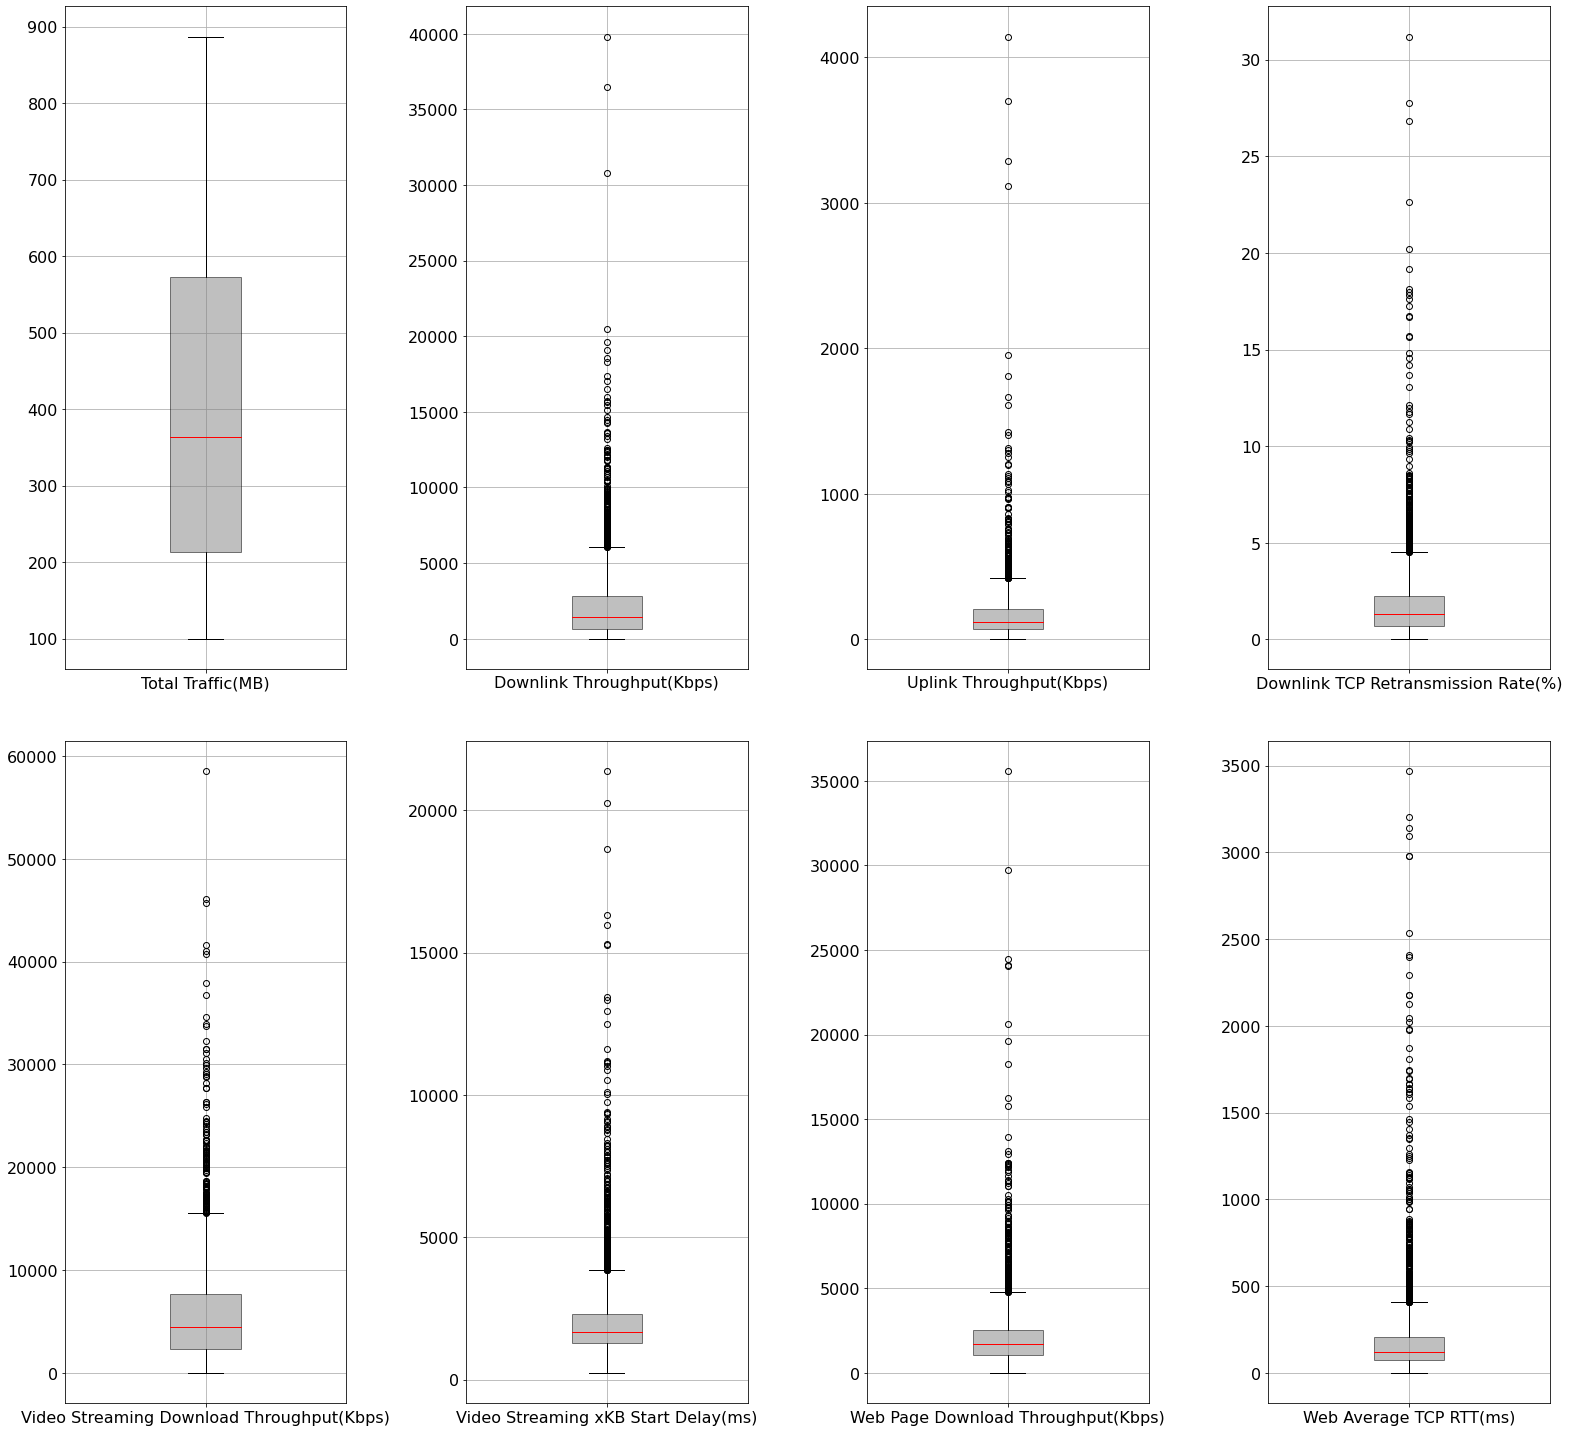

In [93]:
# Визуализация выбросов

dt = df_1[features]

fig = plt.figure(figsize=(22,20))

for column in dt:
    n = list(dt).index(column)
    ax = fig.add_subplot(2, 4, (n+1))
    ax = dt.boxplot(column, meanline=True, color='black', fontsize=16,  
                    widths=0.25, patch_artist=True,
                    boxprops=dict(facecolor='gray', alpha=0.5, color='black'),
                    medianprops=dict(color='red'))

plt.tight_layout(h_pad=5.0)     
plt.show()  

Кроме объема трафика передачи данных (Total Traffic(MB)),  все остальные показатели не имеют нормального распределения и включают в себя выбросы. Поэтому для предварительного отображения зависимости оценок от характериктик используем медианные значения технических показателей.

In [6]:
# Формирование датасета  медианных значений

medians = df_1.groupby('Q1').median()
medians['ReviewCount'] = df_1.groupby('Q1')['Q1'].count()
medians.reset_index(inplace=True)

In [7]:
# Визуализация зависимости медианных значений технических характеристик и отзывов

data = medians[features]

fig = go.Figure()

for feature in data:
    ylim = [medians[feature].min()*0.98, medians[feature].max()*1.02]
    fig.add_trace(
        go.Scatter(
            x = medians['ReviewCount'],
            y = medians[feature],
            visible=False,
            name = str(feature),
            mode='markers',
            marker=dict(
                   color=medians['Q1'],
                   size=medians['ReviewCount']/10,
                   showscale=True,
                   colorscale="Viridis"),
            text=medians['Q1']))
start_index = 0
fig.data[start_index].visible = True

steps = []
for i in range(len(fig.data)):
    step = dict(
        label=fig.data[i].name,
        method="update",
        args = [{'visible': [t == i for t in range(len(fig.data))]},
                {'title.text': 'Customer review scores for median {} '.format(fig.data[i].name)},],)
    steps.append(step)
    
fig.update_layout(
    updatemenus=[dict(type="buttons",
                      x=-0.1,
                      y=0.9,
                      xanchor="right",
                      buttons=steps)])         
fig.update_layout({'xaxis': {'dtick': 150, 'range':  [10,1000], 'title': 'Scores Count'},
                    'template': 'none',
                    'title': 'Customer review scores'}) 
fig.show() 


### 1.3 Статистический тест

Визуально, исследуя медианные значения на графике, можно предположить, что качественные показатели связи определяют высокие оценки. Проверим - есть ли зависимость, предварительно выбрав оценочный параметр и сформулировав гипотезу.

**ОЦЕНОЧНЫЙ ПАРАМЕТР:**

В данном случае, для проверки зависимости, воспользуемся **коэффициентом корреляции Пирсона** как оценочным параметром.

Определим для каждого признака:
 - коэффициент корреляции Пирсона относительно оценок;
 - 95% доверительный интервал для него методом парного bootstrap.
 
 
**СТАТИСТИЧЕСКАЯ ГИПОТЕЗА:**

Протестируем следующую гипотезу: **оценка абонента не зависит от значения признака связи**.

Для этого переставим значения признака, но оставим фиксированными значения оценки. Для каждой перестановки вычислим коэффициент корреляции Пирсона и оценим, сколько повторений перестановки имеют коэффициент корреляции Пирсона выше наблюдаемого.
Для проверки статистической значимости используем значение p_value.


In [96]:
# Функция для расчета коэффициента Пирсона

def pearson_r(x, y):
    """Вычисление коэффициента корреляции Пирсона."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]


In [97]:
# Функция для расчета парного bootstrap

def draw_bs_pairs(x, y, func, size=1):
    """Реализация парного bootstrap с одной статистикой."""
    inds = np.arange(len(x))

    # Инициализация реплик
    bs_replicates = np.empty(size)

    # Реализация реплик
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x.reindex(bs_inds), y.reindex(bs_inds)
        bs_replicates[i] = pearson_r(bs_x.dropna(), bs_y.dropna())

    return bs_replicates

In [98]:
# Функция для исключения выбросов с помощью правила трех сигм:

def trimming(column):
    # Наблюдаемое отклонение от среднего
    dev = (column - column.mean()).abs()
    # Стандартное отклонение
    std = column.std()
    # Фильтр исходного набора данных
    return column[~(dev>3*std)]

In [100]:
# Перестановочный тест

for feature in features:
    feature_trimmed = trimming(df_1[feature])
    Q1_reindexed = df_1.Q1.reindex(feature_trimmed.index)
    
    # Вычисление корреляции наблюдаемых данных
    r_obs = pearson_r(feature_trimmed, Q1_reindexed)
    
    # Реализация 1000 bootstrap реплик  pearson_r
    bs_replicates = draw_bs_pairs(feature_trimmed, Q1_reindexed, pearson_r, 1000)

    # Вычисление 95% доверительных интервалов
    conf_intervals = np.percentile(bs_replicates, [2.5, 97.5]) 
       
    # Инициализация реплик
    perm_replicates = np.empty(10000)

    # Создание реплик
    for i in range(10000):
        # Перестановка feature_trimmed
        feature_permuted = np.random.permutation(feature_trimmed)

        # Вычисление корреляции Пирсона
        perm_replicates[i] = pearson_r(feature_permuted, Q1_reindexed)
      
    p = np.sum(abs(perm_replicates) >= abs(r_obs)) / len(perm_replicates) 
    
    print("{0}: \n Pearson corr_coeff: {1}, \n 95% confidence interval: {2}, \n p-value = {3}\n"\
          .format(feature, r_obs.round(3), conf_intervals, p))

Total Traffic(MB): 
 Pearson corr_coeff: -0.007, 
 95% confidence interval: [-0.04113196  0.02859221], 
 p-value = 0.6992

Downlink Throughput(Kbps): 
 Pearson corr_coeff: 0.139, 
 95% confidence interval: [0.10532161 0.17117459], 
 p-value = 0.0

Uplink Throughput(Kbps): 
 Pearson corr_coeff: 0.07, 
 95% confidence interval: [0.03089863 0.10044798], 
 p-value = 0.0

Downlink TCP Retransmission Rate(%): 
 Pearson corr_coeff: -0.095, 
 95% confidence interval: [-0.13166827 -0.05349959], 
 p-value = 0.0

Video Streaming Download Throughput(Kbps): 
 Pearson corr_coeff: 0.131, 
 95% confidence interval: [0.09884263 0.16902282], 
 p-value = 0.0

Video Streaming xKB Start Delay(ms): 
 Pearson corr_coeff: -0.14, 
 95% confidence interval: [-0.17324794 -0.10237967], 
 p-value = 0.0

Web Page Download Throughput(Kbps): 
 Pearson corr_coeff: 0.124, 
 95% confidence interval: [0.08778622 0.16049214], 
 p-value = 0.0

Web Average TCP RTT(ms): 
 Pearson corr_coeff: -0.114, 
 95% confidence interval

### 1.4 Вывод:

Итак, для **Total Traffic(MB) гипотеза о независимости подтверждается, оценка не зависит от объема потребляемого трафика передачи данных**. Тогда как **для признаков, определяющих качество связи, гипотеза не подтверждается**, оценочный парметр в пределах 95% доверительного интервала и p-value = 0.0 < 0.05, при этом **коэффициент корелляции довольно низкий**. 

**ВЫВОД:** прямая зависимость оценки (по шкале 1-10) от качества характеристик связи есть, но довольно слабая, чтобы полагаться на нее.

## ЧАСТЬ 2. Исследование разницы качества  связи между абонентами с высокими и низкими оценками по опросу Q1

### 2.1 Подготовка данных и постановка задачи

В предыдущем разделе исследование показало слабую корелляцию между качеством связи и оценкой абонента. Здесь сравним данные  абонентов, высоко оценивших качество связи, со всеми остальными.
Для этого в первую группу включаем клиентов с оценками 10 и 9, во вторую - с 8 по 1.

In [7]:
# Данные, включающие отзывы 10 и 9
high_scores = df_1.query('Q1 == [9, 10]')[features]

# Данные, включающие отзывы 8-1
low_scores = df_1.query('Q1 != [9, 10]')[features]

**ЗАДАЧА:** Определить, есть ли существенная разница между качеством связи абонентов с хорошими отзывами и качеством связи абонентов с оценками от 8 и ниже.

### 2.2 Разведочный анализ (EDA)

Посмотрим на сравнение распределений данных в обоих группах по каждому признаку, используя эмпирическую кумулятивную функцию распределения (ECDF), предварительно удалив выбросы.

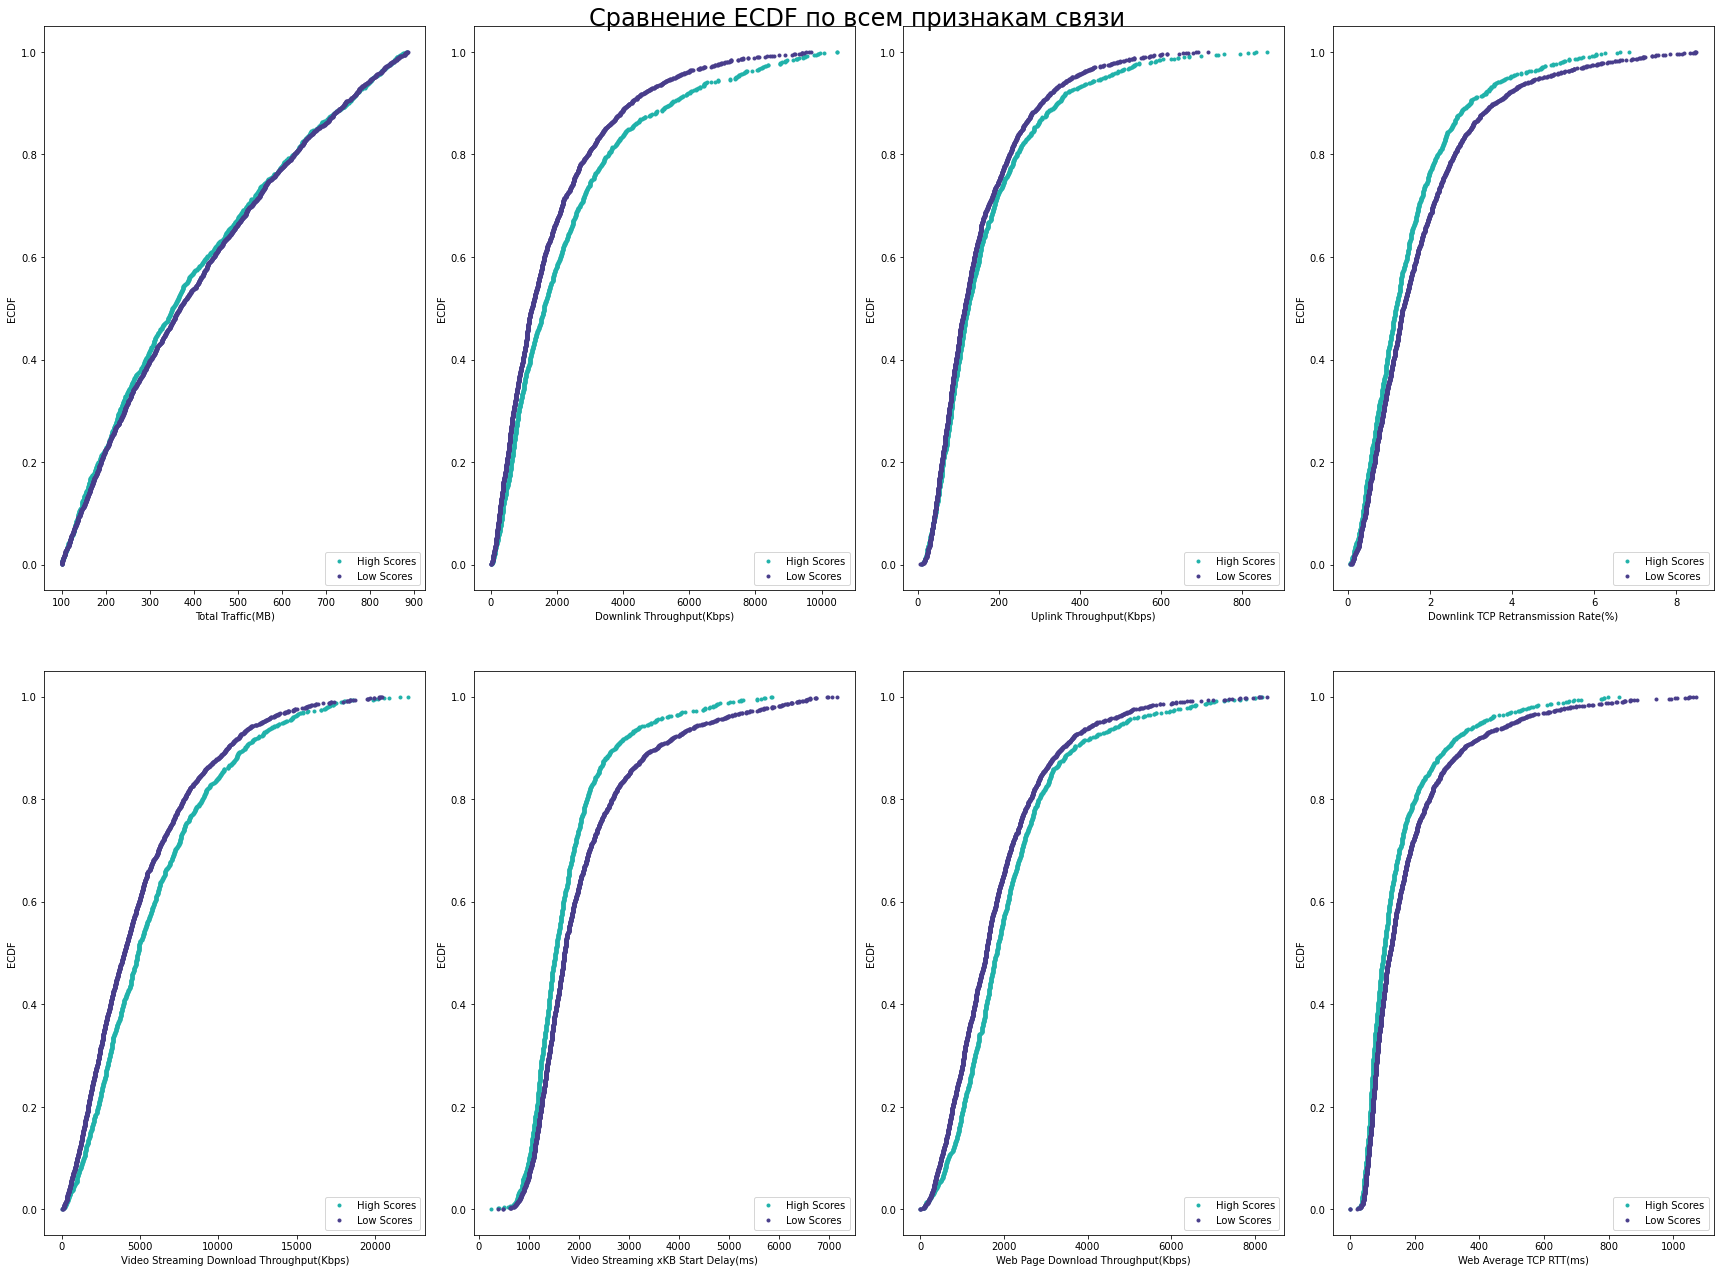

In [296]:
# Визуализация сравнения графиков ECDF

fig = plt.figure(figsize=(24,18))
fig.suptitle("Сравнение ECDF по всем признакам связи " + str(), fontsize=24)

for feature in features:
    n = features.index(feature)
    ax = fig.add_subplot(2, 4, (n+1))
        
    # Создание выборок и исключение выбросов
    high = trimming(high_scores[feature])
    low = trimming(low_scores[feature])
        
    # Определение координат
    x_high, y_high = ECDF(high).__dict__['x'], ECDF(high).__dict__['y']
    x_low, y_low = ECDF(low).__dict__['x'], ECDF(low).__dict__['y']

    ax = plt.plot(x_high, y_high, marker='.', linestyle='none', color='LightSeaGreen')
    ax = plt.plot(x_low, y_low, marker='.', linestyle='none', color='DarkSlateBlue')
    ax = plt.xlabel(feature)
    ax = plt.ylabel('ECDF')
    ax = plt.legend(('High Scores', 'Low Scores'), loc='lower right')
        
plt.tight_layout(h_pad=5.0)     
plt.show() 

Исключая Total Traffic(MB), по всем остальным характеристикам наблюдается разница в распределении данных.

### 2.3 Статистический тест

**ФОРМУЛИРОВАНИЕ ГИПОТЕЗЫ**

Проверим одновременно две гипотезы:

 1. Среднее значение признака связи у абонентов с высокой оценкой равно среднему значению признака связи у абонентов с низкой оценкой. **Mean(high) = Mean(low)**. Проверим с помощью доверительных интервалов, используя метод bootstrap.
 
 
 2. Распределения в обоих случаях идентичны. **F_high(x) = F_low(x)**. Используем перестановочный тест с тестовой статистикой разности средних (**diff_of_means**) для проверки этой гипотезы. 


In [8]:
#Создание функции для bootstrap реплик

def draw_bs_reps(data, func, size=1):
    """Drawing bootstrap replicates."""
    
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, len(data)))
    return bs_replicates

In [9]:
# Функция для перестановочного теста для двух выборок

def permutation_sample(data1, data2):
    """Генерация перестановочной выборки из двух."""

    # Объединение двух выборок
    data = np.concatenate((data1, data2))

    # Перестановка объединенной выборки
    permuted_data = np.random.permutation(data)

    # Разделение на две новые выборки
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

# Функция для перестановочного теста с использованием функции

def draw_perm_reps(data_1, data_2, func, size=1):
    """Генерация перестановочных реплик 
    с использованием функции (тестовой статистики)."""

    # Инициализация реплик
    perm_replicates = np.empty(size)

    for i in range(size):
        # Генерация перестановочной выборки
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Вычисление функции
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


# Функция для определения разницы средних

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # Разница средних data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

Для наглядности результатов рассчитаем за один цикл по каждой характеристике:
 - средние значения и их разницу;
 - доверительные интервалы для них, используя bootstrap;
 - инициализуем перестановочный тест с diff_of_means;
 - определим p-value статистической значимости теста.

In [22]:
# Статистический тест для каждой характеристики

for feature in features:
    
    # Создание выборок и исключение выбросов
    high = trimming(high_scores[feature])
    low = trimming(low_scores[feature])
        
    # Вычисление разницы средних значений
    mean_diff = abs(np.mean(high)) - abs(np.mean(low))
    mean_diff_perc = mean_diff *100 / abs(np.mean(high))
        
    # Получение bootstrap реплик средних значений
    bs_replicates_h = draw_bs_reps(high, np.mean, 10000)
    bs_replicates_l = draw_bs_reps(low, np.mean, 10000)
    
    # Вычисление 95% доверительных интервалов
    conf_int_h = np.percentile(bs_replicates_h, [2.5, 97.5])
    conf_int_l = np.percentile(bs_replicates_l, [2.5, 97.5])
        
    # Создание 10,000 перестановочных реплик
    perm_replicates = draw_perm_reps(high, low, diff_of_means, size=10000)
    
    # Расчет коэффициента p-value
    p = np.sum(abs(perm_replicates) >= abs(mean_diff)) / len(perm_replicates)  
    
    print("{0}: \n mean_diff =  {1}, ({2} %), \n 95% confidence intervals: {3}, {4} \n p-value = {5}\n"\
          .format(feature, round(mean_diff, 2), round(mean_diff_perc, 2), conf_int_h, conf_int_l, p))
    

Total Traffic(MB): 
 mean_diff =  -7.66, (-1.91 %), 
 95% confidence intervals: [387.72013609 414.14829476], [398.85039543 418.26384839] 
 p-value = 0.3615

Downlink Throughput(Kbps): 
 mean_diff =  459.65, (19.98 %), 
 95% confidence intervals: [2172.10218411 2429.98049346], [1764.5117683  1919.99273849] 
 p-value = 0.0

Uplink Throughput(Kbps): 
 mean_diff =  16.29, (9.84 %), 
 95% confidence intervals: [157.58339539 173.72357199], [144.08611206 154.32338807] 
 p-value = 0.0009

Downlink TCP Retransmission Rate(%): 
 mean_diff =  -0.28, (-18.96 %), 
 95% confidence intervals: [1.41745631 1.55832991], [1.70589921 1.83409939] 
 p-value = 0.0

Video Streaming Download Throughput(Kbps): 
 mean_diff =  847.93, (14.54 %), 
 95% confidence intervals: [5586.89590798 6080.20889178], [4812.65203423 5158.05886051] 
 p-value = 0.0

Video Streaming xKB Start Delay(ms): 
 mean_diff =  -318.12, (-18.15 %), 
 95% confidence intervals: [1702.4880066  1803.69856268], [2018.63466752 2122.19375959] 
 p-

### 2.4 Вывод

Получается следующее:

- **для Total Traffic(MB)** обе гипотезы подтверждаются, средние значения и распределения по выборкам близки. Как и в предыдущем тесте, можно сказать, что **отзыв клиента не зависит от объема потребляемого трафика**.
- **для всех остальных признаков гипотезы не подтверждаются**, так как доверительные интервалы не пересекаются, а p-value < 0.05. А это значит, что **с 95% вероятностью  показатели характеристик с высокими и низкими оценками клиентов статистически достоверно различаются**.

**ВЫВОД:** Качество связи у абонентов с оценками 9 и 10 по всем показателям (исключая Total Traffic) значимо лучше, чем у остальных. Самая большая разница значений по характеристикам:
  - Downlink Throughput(Kbps) **19.98 %**  - средняя скорость «к абоненту»;
  - Video Streaming xKB Start Delay(ms) **-18.15 %**  - задержка старта воспроизведения видео;
  - Web Average TCP RTT(ms) **-19.77 %** - пинг при просмотре web-страниц.


## ЧАСТЬ 3. Исследование технических показателей связи у абонентов с наибольшим количеством отрицательных отзывов по Q2

### 3.1 Подготовка данных и постановка задачи для исследования

Изучение данных по столбцу Q2:

In [114]:
megafon['Q2'].count()

1315

Из 3112 опрошенных абонентов лишь 1315 ответили на вопросы Q2. Посмотрим на содержание отзывов:

In [28]:
megafon.groupby('Q2')['Q2'].count()    

Q2
0                     1
0, 05, 2, 27, 7       1
0, 1, 7               1
0, 3                  1
1                   168
1, 2                 22
1, 2, 3              44
1, 2, 3, 4           18
1, 2, 3, 4, 5        27
1, 2, 3, 4, 5, 6      2
1, 2, 3, 4, 7         1
1, 2, 3, 5            4
1, 2, 3, 7            1
1, 2, 34              1
1, 2, 4              11
1, 2, 4, 5            4
1, 2, 5               3
1, 2, 7               1
1, 3                121
1, 3, 4              76
1, 3, 4, 5           40
1, 3, 4, 5, 7         2
1, 3, 4, 7            2
1, 3, 5               3
1, 3, 7               2
1, 4                 56
1, 4, 5              27
1, 4, 7               3
1, 5                  7
10                    1
2                    11
2, 3                 12
2, 3, 4              11
2, 3, 4, 5            3
2, 4                  4
2, 4, 5               2
2, 5                  1
3                   190
3, 4                 85
3, 4, 5              45
3, 4, 5, 7            3
3, 4, 7      

Отсортируем оценки, оставив лишь отзывы, включающие числа от 1 до 7.

In [8]:
# Очистка и преобразование данных

megafon['Q2']= megafon.Q2.astype(str)
megafon['Q2'] = [re.findall(r'\d', x) if re.match(r'[1-7]{1}', x) else np.nan for x in megafon['Q2']]

In [128]:
megafon['Q2'].count()

1311

Сгруппируем данные по оценкам от 1 до 7 и посмотрим, какие из них наиболее часто встречаются в отзывах:

In [9]:
# Данные для визуализации 
Q2_pie = megafon.copy().explode('Q2').groupby('Q2')['Q2'].count()[1:]

# Визуализация процентного соотношения отзывов о качестве связи
reviews=["1 Недозвоны, обрывы при звонках", 
          "2 Время ожидания гудков при звонках", 
          "3 Плохое качество связи в зданиях, торговых центрах и т.п.",
          "4 Медленный мобильный Интернет",
          "5 Медленная загрузка видео",
          "6 Затрудняюсь ответить",
          "7 Свой вариант"]

colors = ['Indigo', 'DarkSlateBlue', 'Gold',
          'SeaGreen', 'MediumSeaGreen', 
          'YellowGreen', 'LightSeaGreen']

pie_2 = go.Figure(go.Pie(
    values = Q2_pie,
    labels = reviews,
    pull=[0, 0, 0.2, 0, 0, 0, 0, 0],
    texttemplate = " %{percent}",
    textposition = "inside"
))
pie_2.update_traces(opacity=0.75,
                    marker=dict(colors=colors))
pie_2.update_layout(title = 'Customer reviews Q2 ') 
pie_2.show()

Рассматривая ответы 1315 пользователей, ответивших на Q2, заметно, что наибольшее количество отзывов содержат оценки:

 - 3 Плохое качество связи в зданиях, торговых центрах и т.п (28.4%),
 - 1 Недозвоны, обрывы при звонках (26.1%),
 - 4 Медленный мобильный Интернет (25.3%).
 

**ПОСТАНОВКА ЗАДАЧИ:**

Выявить, действительно ли, качество связи хуже у потребителей с оценками 3,1,4?
И, если да, то из-за каких признаков.
Чтобы сформулировать статистическую гипотезу для исследования, проведем разведочный анализ имеющихся данных и определим оценочные параметры.


### 3.2 Разведочный анализ (EDA)

Для разведочного анализа используем эмпирическую кумулятивную функцию распределения (ECDF). Сравним распределение данных по каждому признаку для каждого из выбранных для рассмотрения отзыва с данными, не включающими исследуемый отзыв.

In [80]:
from statsmodels.distributions.empirical_distribution import ECDF

data_Q2 = megafon.copy()

#Создание функции для визуализации распределения

def EDA(data, score_review, new_col_name):
    """Создает новый столбец с исследуемой характеристикой, 
       делит выборку на две, визуализирует ECDF"""
    
    # Создание нового столбца
    data.loc[:, new_col_name] = [1 if str(score_review) in x else 0 for x in data['Q2']]
    
    # Разделение выборки на две
    data_yes = data[data[new_col_name] == 1][features]
    data_no = data[data[new_col_name] == 0][features]
    
    # Визуализация ECDF
    fig = plt.figure(figsize=(22,16))
    fig.suptitle("Сравнение ECDF по всем признакам связи, Review:  " + str(score_review), fontsize=24)
    
    for feature in features:
        n = features.index(feature)
        ax = fig.add_subplot(2, 4, (n+1))

        # Исключение выбросов
        feature_yes = trimming(data_yes[feature]) 
        feature_no = trimming(data_no[feature]) 
        
        # Определение координат
        x_yes, y_yes = ECDF(feature_yes).__dict__['x'], ECDF(feature_yes).__dict__['y']
        x_no, y_no = ECDF(feature_no).__dict__['x'], ECDF(feature_no).__dict__['y']

        ax = plt.plot(x_yes, y_yes, marker='.', linestyle='none', color='YellowGreen')
        ax = plt.plot(x_no, y_no, marker='.', linestyle='none', color='DarkSlateBlue')
        ax = plt.xlabel(feature)
        ax = plt.ylabel('ECDF')
        ax = plt.legend(('Review: ' + str(score_review), 'Other'), loc='lower right')
        
    plt.tight_layout(h_pad=5.0)     
    plt.show() 

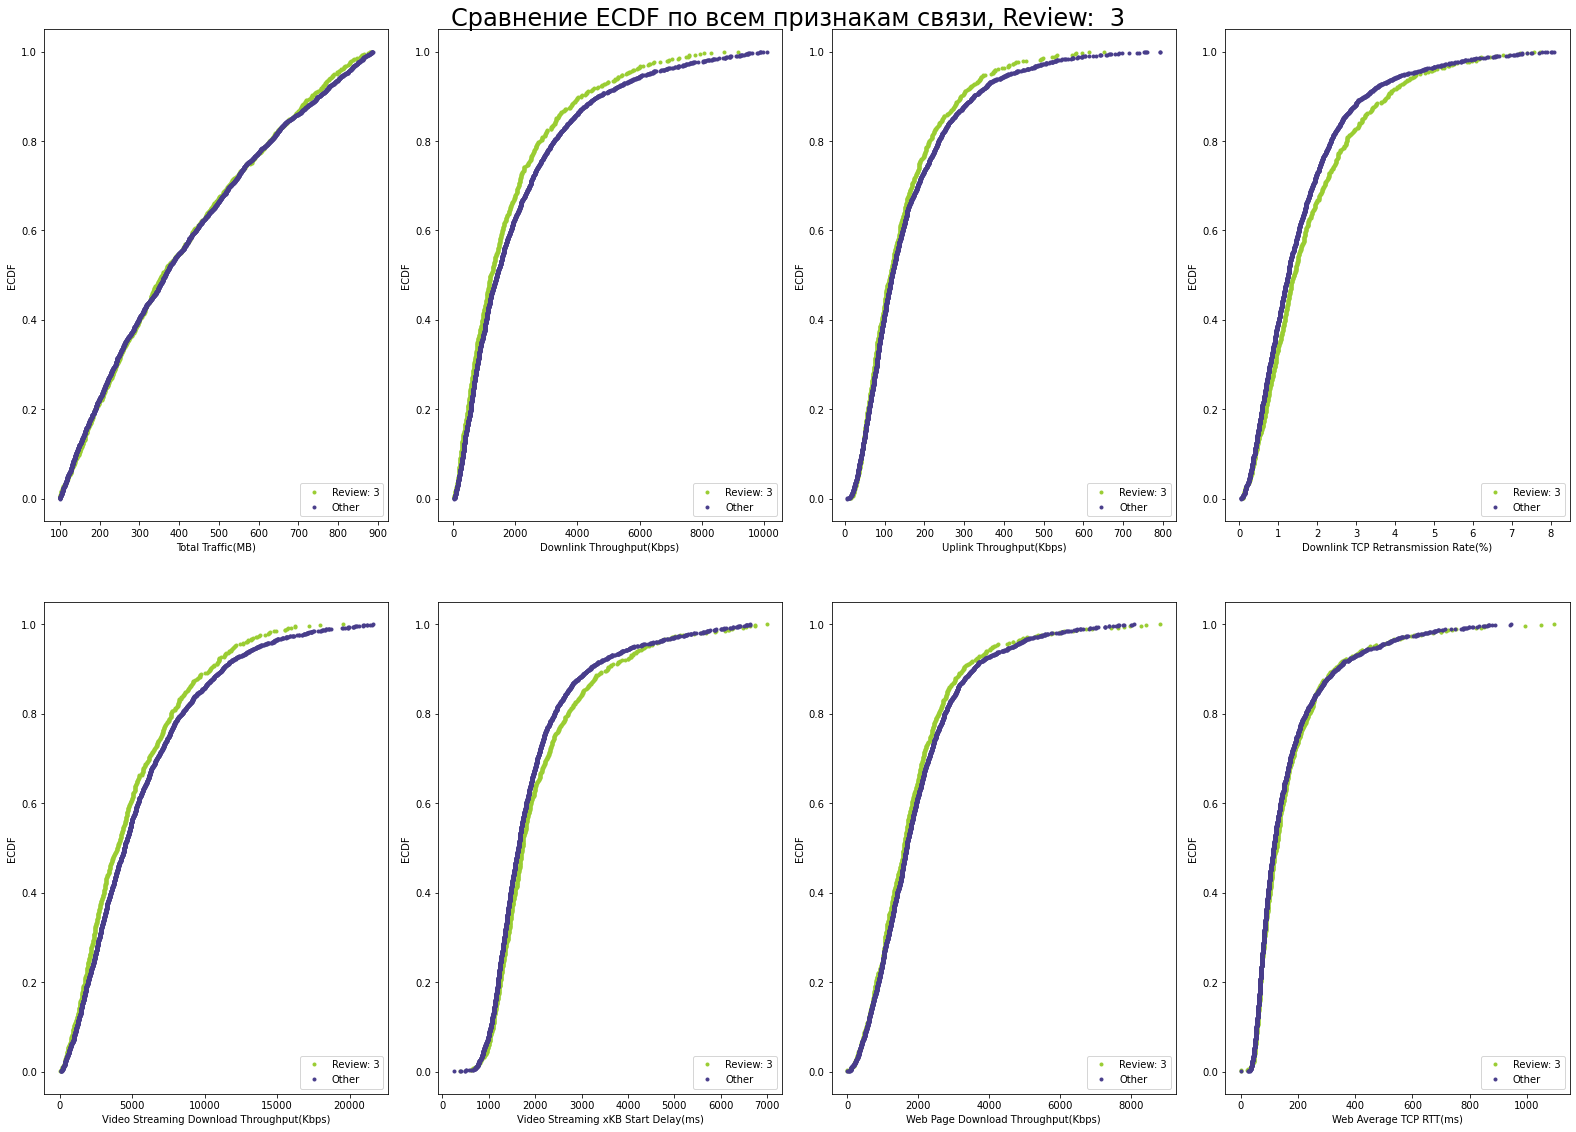

In [81]:
# Визуализация сравнения распределений при отзыве 3
EDA(data_Q2, score_review=3, new_col_name='is_r3')

### 3.3 Статистический тест отзыва (3-Плохое качество связи в зданиях, торговых центрах и т.п (28.4%)

**ОЦЕНОЧНЫЙ ПАРАМЕТР:**

Можно заметить, что распределения по многим признакам различаются, соответственно, выбираем значения средних (Mean) как оценочный параметр, исключая выбросы из данных.

Определим для каждого признака:
- разницу средних значений;
- 95% доверительный интервал для нее (с использованием метода bootstrap).

**СТАТИСТИЧЕСКАЯ ГИПОТЕЗА:**

Протестируем следующую гипотезу: среднее значение признака связи у абонентов с отзывом (3) равно среднему значению признака связи у абонентов с отзывом, не включающим (3). 
**Mean(review:3) = Mean(other)**

Чтобы выполнить эту проверку гипотезы, нам нужно сдвинуть два набора данных так, чтобы они имели одинаковое среднее значение, а затем использовать bootstrap-выборку для вычисления разницы средних значений.
Для проверки статистической значимости используем значение p_value.

Все необходимые вычисления включены в функцию hypothesis_test().

In [29]:
def hypothesis_test(data, features, review_col_name):
    
    for feature in features:
        # Разделение выборки
        data_yes = data[data[review_col_name] == 1][[feature]].apply(trimming)
        data_no = data[data[review_col_name] == 0][[feature]].apply(trimming)
        
        # Вычисление разницы средних значений
        mean_diff = np.mean(data_yes) - np.mean(data_no)
        mean_diff_perc = mean_diff * 100 / np.mean(data_yes)
        
        # Получение bootstrap реплик средних значений
        bs_replicates_y = draw_bs_reps(data_yes.iloc[:,0], np.mean, 10000)
        bs_replicates_n = draw_bs_reps(data_no.iloc[:,0], np.mean, 10000)
        
        # Вычисление разницы двух выборок
        bs_diff_repl = bs_replicates_y - bs_replicates_n
        
        # Вычисление 95% доверительных интервалов
        conf_int = np.percentile(bs_diff_repl, [2.5, 97.5])
    
        # Вычисление среднего значения объединенной выборки
        combined_mean = np.mean(np.concatenate((data_yes, data_no)))
    
        # Сдвиг в выборках с заменой средних значений на combined_mean
        data_yes_shifted = data_yes - np.mean(data_yes) + combined_mean
        data_no_shifted = data_no - np.mean(data_no) + combined_mean
    
        # Получение bootstrap реплик "сдвинутых" выборок                                         
        bs_replicates_yes = draw_bs_reps(data_yes_shifted.iloc[:,0], np.mean, size=10000)
        bs_replicates_no = draw_bs_reps(data_no_shifted.iloc[:,0], np.mean, size=10000)
    
        # Вычисление разницы bootstrap реплик
        bs_diff_replicates = bs_replicates_yes - bs_replicates_no
    
        # Расчет коэффициента p-value
        p = np.sum(abs(bs_diff_replicates) >= abs(mean_diff[0])) / len(bs_diff_replicates)
        
        print("{0}: \n mean_diff = {1},  ({2} %), \n 95% confidence interval: {3}, \n p-value = {4}\n"\
              .format(feature, round(mean_diff[0], 2), round(mean_diff_perc[0], 2), conf_int, p))
    

Вычисляем для каждого признака разницу средних значений, 95% доверительный интервал для нее и значение p-value:

In [30]:
hypothesis_test(data_Q2, features=features, review_col_name='is_r3')

Total Traffic(MB): 
 mean_diff = -1.98,  (-0.49 %), 
 95% confidence interval: [-19.59234807  16.2855994 ], 
 p-value = 0.8364

Downlink Throughput(Kbps): 
 mean_diff = -274.15,  (-15.37 %), 
 95% confidence interval: [-422.0210277  -126.20617721], 
 p-value = 0.0004

Uplink Throughput(Kbps): 
 mean_diff = -12.89,  (-8.9 %), 
 95% confidence interval: [-22.28199955  -3.38721482], 
 p-value = 0.0071

Downlink TCP Retransmission Rate(%): 
 mean_diff = 0.21,  (11.45 %), 
 95% confidence interval: [0.0924391  0.32903465], 
 p-value = 0.0008

Video Streaming Download Throughput(Kbps): 
 mean_diff = -590.01,  (-12.16 %), 
 95% confidence interval: [-916.25626247 -264.48172702], 
 p-value = 0.0002

Video Streaming xKB Start Delay(ms): 
 mean_diff = 140.18,  (6.79 %), 
 95% confidence interval: [ 48.36296223 233.36653729], 
 p-value = 0.0024

Web Page Download Throughput(Kbps): 
 mean_diff = -99.98,  (-5.46 %), 
 95% confidence interval: [-208.36113288   11.91666012], 
 p-value = 0.0755

Web A

### 3.4 Статистический тест отзыва (1 - Недозвоны, обрывы при звонках (26.1%)

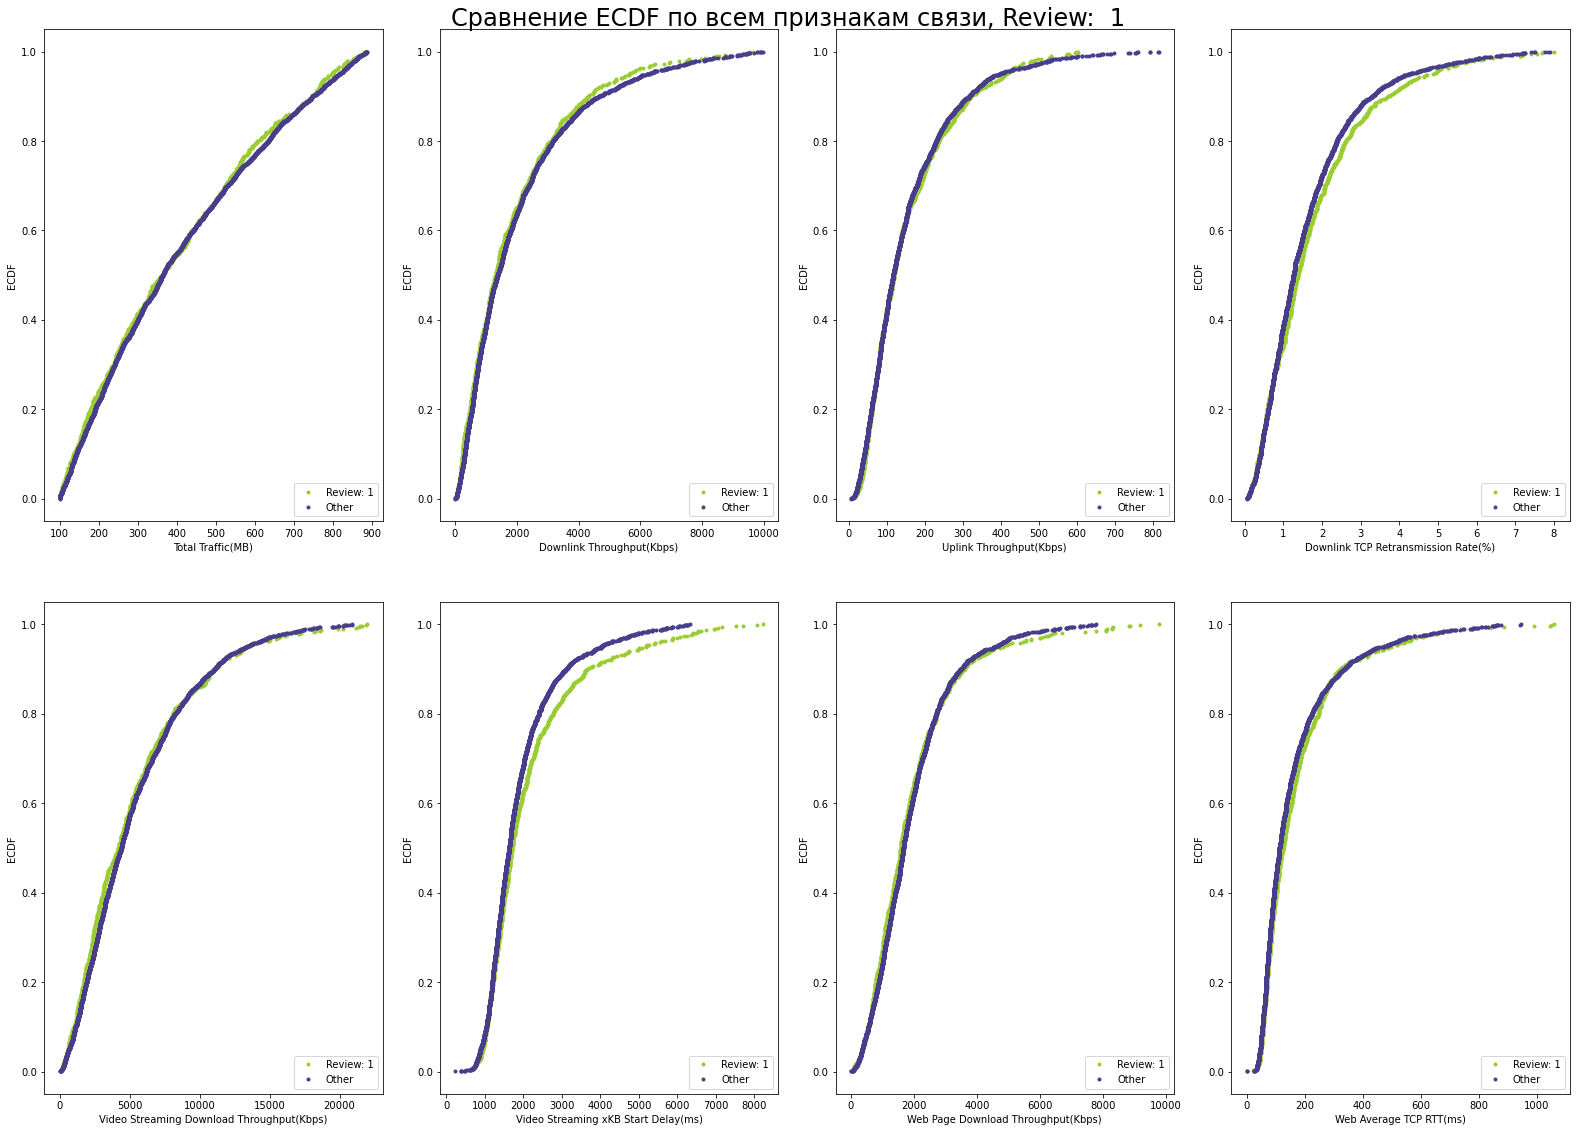

In [82]:
# Визуализация сравнения распределений
EDA(data_Q2, score_review=1, new_col_name='is_r1')

In [46]:
# Статистический тест
hypothesis_test(data_Q2, features=features, review_col_name='is_r1')

Total Traffic(MB): 
 mean_diff = -7.3,  (-1.82 %), 
 95% confidence interval: [-26.14946447  11.93522426], 
 p-value = 0.4472

Downlink Throughput(Kbps): 
 mean_diff = -118.05,  (-6.19 %), 
 95% confidence interval: [-275.59699689   46.3529703 ], 
 p-value = 0.1465

Uplink Throughput(Kbps): 
 mean_diff = 2.0,  (1.28 %), 
 95% confidence interval: [-8.21501092 12.40339768], 
 p-value = 0.7066

Downlink TCP Retransmission Rate(%): 
 mean_diff = 0.14,  (7.96 %), 
 95% confidence interval: [0.02063152 0.26589948], 
 p-value = 0.0257

Video Streaming Download Throughput(Kbps): 
 mean_diff = -101.44,  (-1.94 %), 
 95% confidence interval: [-471.14923816  267.98161228], 
 p-value = 0.5846

Video Streaming xKB Start Delay(ms): 
 mean_diff = 240.31,  (11.22 %), 
 95% confidence interval: [133.26085681 350.34820986], 
 p-value = 0.0

Web Page Download Throughput(Kbps): 
 mean_diff = 21.06,  (1.09 %), 
 95% confidence interval: [-105.15335475  149.87866389], 
 p-value = 0.7468

Web Average TCP RT

### 3.5 Статистический тест отзыва (4 - Медленный мобильный Интернет (25.3%)

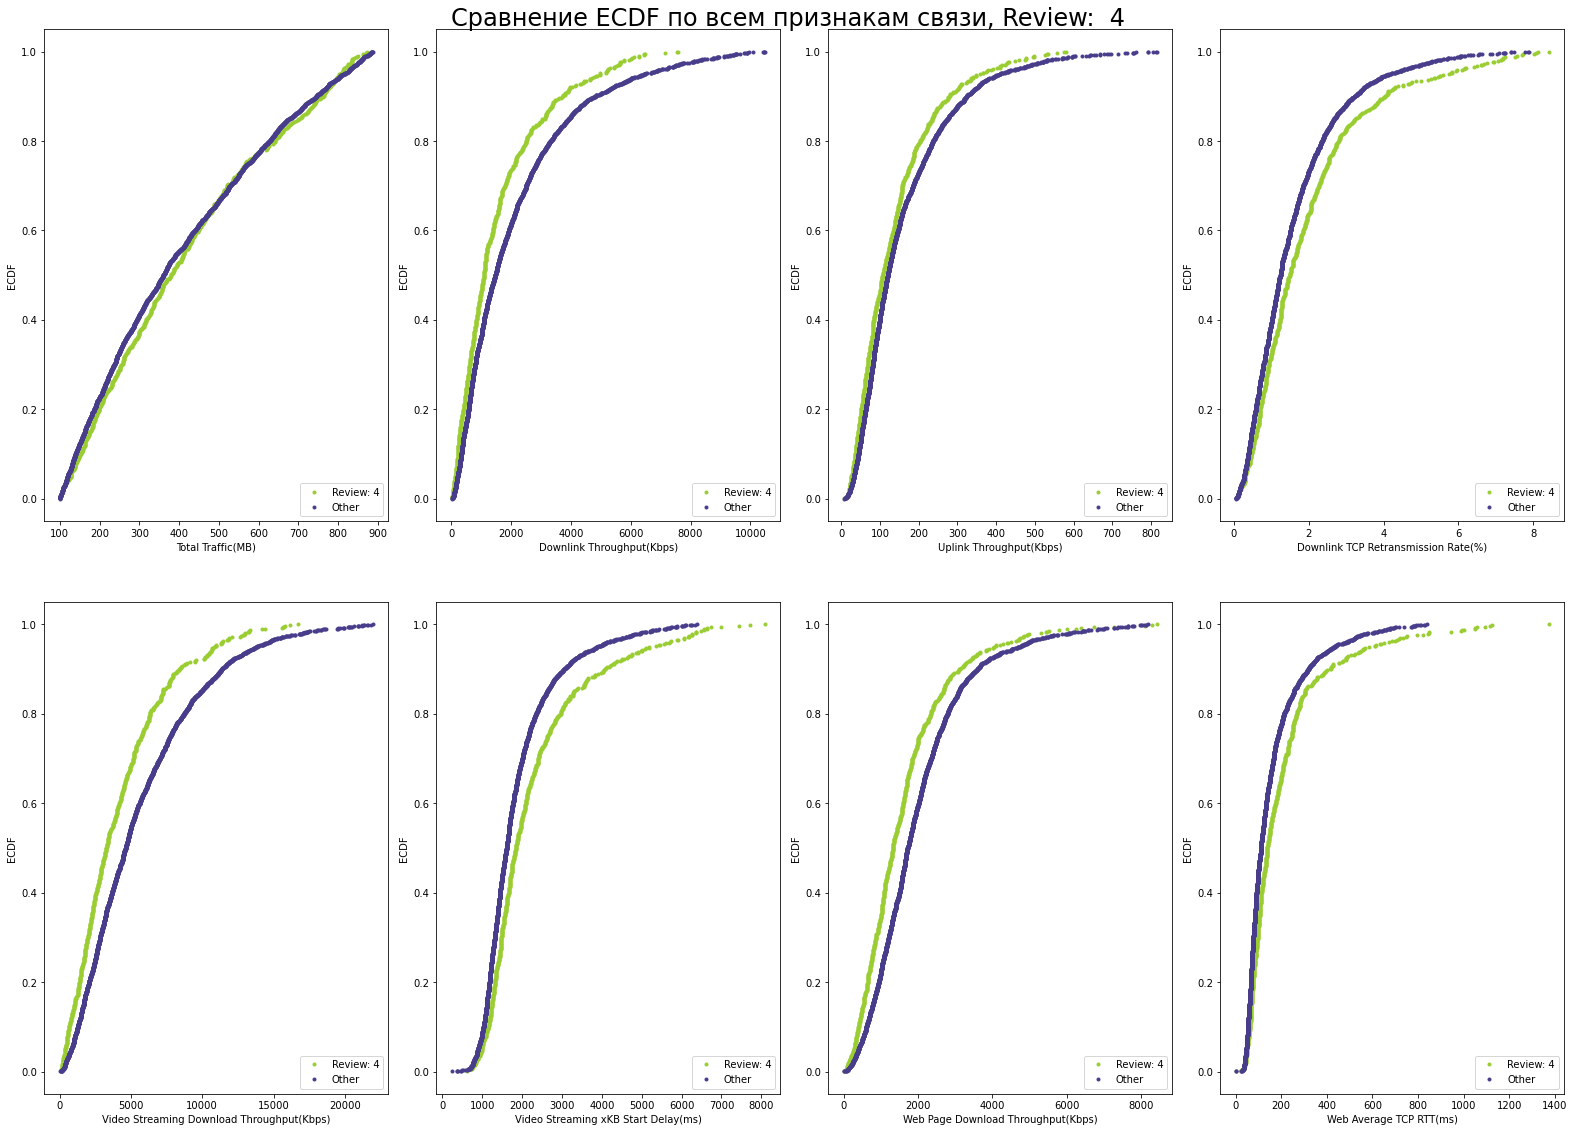

In [83]:
# Визуализация сравнения распределений
EDA(data_Q2, score_review=4, new_col_name='is_r4')

In [48]:
# Статистический тест
hypothesis_test(data_Q2, features=features, review_col_name='is_r4')

Total Traffic(MB): 
 mean_diff = 10.8,  (2.6 %), 
 95% confidence interval: [-8.21630877 30.09217723], 
 p-value = 0.2652

Downlink Throughput(Kbps): 
 mean_diff = -546.38,  (-34.91 %), 
 95% confidence interval: [-689.11975341 -403.46670392], 
 p-value = 0.0

Uplink Throughput(Kbps): 
 mean_diff = -21.94,  (-16.0 %), 
 95% confidence interval: [-31.76383612 -12.03135551], 
 p-value = 0.0

Downlink TCP Retransmission Rate(%): 
 mean_diff = 0.37,  (18.92 %), 
 95% confidence interval: [0.23751829 0.50978875], 
 p-value = 0.0

Video Streaming Download Throughput(Kbps): 
 mean_diff = -1485.92,  (-36.11 %), 
 95% confidence interval: [-1788.35640358 -1175.22089981], 
 p-value = 0.0

Video Streaming xKB Start Delay(ms): 
 mean_diff = 400.2,  (17.65 %), 
 95% confidence interval: [291.1527312  511.42332504], 
 p-value = 0.0

Web Page Download Throughput(Kbps): 
 mean_diff = -378.68,  (-23.48 %), 
 95% confidence interval: [-489.67696883 -267.1106369 ], 
 p-value = 0.0

Web Average TCP RTT(ms

### 3.6 Вывод

Итак, на основе полученных данных, можно предположить, что:
- средние значения показателей связи у абонентов с отзывом (**3- Плохое качество связи в зданиях, торговых центрах и т.п (28.4%)**) отличаются в худшую сторону. Но с 95% вероятностью статистически достоверно различаются следующие параметры:

  **Downlink Throughput(Kbps):           mean_diff = -274.15**, p-value = 0.0003 < 0.05.

  **Uplink Throughput(Kbps):             mean_diff = -12.89**,  p-value = 0.0075 < 0.05.

  **Downlink TCP Retransmission Rate(%): mean_diff = 0.21**,    p-value = 0.0005 < 0.05.

  **Video Streaming xKB Start Delay(ms): mean_diff = 140.18**,  p-value = 0.0031 < 0.05.

   Гипотеза о равенстве средних для этих показателей не подтверждается.

 - в случае **(1 - Недозвоны, обрывы при звонках (26.1%)**, гипотеза о равенстве средних не подтверждается, и разница с 95% вероятностью статистически значима  лишь для параметра:

   **Video Streaming xKB Start Delay(ms):    mean_diff =  240.31**,   p-value = 0.0001 < 0.05.

- исключая Total Traffic(MB), **все показатели качества связи абонентов с отзывом (4 - Медленный мобильный Интернет (25.3%) с 95% вероятностью статистически достоверно различаются**, так как значение p-value = 0.

## Итоги исследования:

1. Исходные данные для рассмотрения включают в себя информацию о **3112** пользователях компании «Мегафон». Из них **3075** отзывов годны для исследования ответа на вопрос Q1 и  **1310** - для Q2.


2. Основываясь на результатах, очевидно, что объем потребляемого трафика передачи данных **Total Traffic** не влияет на оценку абонента.


3. Отзывы потребителей по Q1, включающие оценки от 1 до 10, хоть и **имеют прямую зависимость с качественными характеристиками связи, все же коэффициент корреляции довольно низкий**, максимальные значения:
 - **Downlink Throughput(Kbps): 0.139**
 - **Video Streaming xKB Start Delay(ms) 0.14**


4. А при разделениии данных (опрос Q1) на две выборки - с высокими (9, 10) и низкими (8-1) оценками, **разница в качестве связи с 95% вероятностью статистически подтверждается по всем показателям**. Наибольшая разница значений по характеристикам:
 - **Downlink Throughput(Kbps) 19.98 %**
 - **Video Streaming xKB Start Delay(ms) -18.15 %**
 - **Web Average TCP RTT(ms) -19.77 %**
 
 
5. При исследовании второго этапа опроса - **Q2** - выделяются три группы наиболее частых оценок:
 - 3 Плохое качество связи в зданиях, торговых центрах и т.п (28.4%),
 - 1 Недозвоны, обрывы при звонках (26.1%),
 - 4 Медленный мобильный Интернет (25.3%).
 
 
6. Анализ отзыва **(3 Плохое качество связи в зданиях, торговых центрах и т.п)** показал статистически достоверную разницу по параметрам:
 - **Downlink Throughput(Kbps) -15.37 %**
 - **Uplink Throughput(Kbps)  -8.9 %**
 - **Downlink TCP Retransmission Rate(%) 11.45 %**
 - **Video Streaming Download Throughput(Kbps) -12.16 %**
 - **Video Streaming xKB Start Delay(ms) 6.79 %**
 
 
7. Статистический тест ответов **(1 Недозвоны, обрывы при звонках)** не подтвердил статической значимости разницы качества характеристик, кроме одной:
 - **Video Streaming xKB Start Delay(ms) 11.22 %**
 
 
8. И наиболее очевидную разницу качества технических показателей выявил анализ ответов (**4 Медленный мобильный Интернет**). **Все характеристики с 95% вероятностью статистически различаются**:

 - Downlink Throughput(Kbps) -34.91 %
 - Uplink Throughput(Kbps)-16.0 %
 - Downlink TCP Retransmission Rate(%) 18.92 %
 - Video Streaming Download Throughput(Kbps) -36.11 %
 - Video Streaming xKB Start Delay(ms) 17.65 %
 - Web Page Download Throughput(Kbps)-23.48 %
 - Web Average TCP RTT(ms) 23.19 %
 
 
9. **В целом**, по результатам всех разделов данного исследования наиболее выделяются две характеристики, разница по которым статистически значима:
 - **Downlink Throughput(Kbps)** - средняя скорость «к абоненту»;
 - **Video Streaming xKB Start Delay(ms)** - задержка старта воспроизведения видео.
 
Высока вероятность того, что именно эти технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов.

Также, можно рекомендовать компании уделить особо внимание абонентам с отзывом, включающим в себя **"4 Медленный мобильный Интернет"**, так как статистически значимая разница почти по всем признакам качества связи здесь довольно высока.